## Computer Vision Simplified Trainer

This notebook is modified from the `00-computer-vision-trainer.ipynb` notebook and has the explanation text removed

The basic steps we'll take are:

1. Importing our collected, organized, and cleaned images
1. Fine-tune a pretrained neural network model to take images as inputs and output category labels
1. Try running this model on a picture from our test dataset and see if it works.

## STOP HERE, THIS IS THE BASE TRAINER, MAKE A COPY AND DO YOUR WORK THERE

Describe what you want to do for this training here:

Item Transforms:

Batch Transforms:

Pre-Trained Model: 

Batch Size:  

Validation Size: 

Epochs: 


## STEP 0: Ensure you are running this notebook within a Docker Container

## STEP 1: Import the image data to the workspace so we can use them to train a model

In [1]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_name = 'lakota_data' # You will want to change this filename to the filename of your data

zip_file_path = f"/workspace/data/{zip_file_name}.zip" # You should not need to edit anything here because the zip_file_path references the variable containing the filename above, this code assumes it will be a zip file
extract_to_dir = '/workspace/data/' # This is where the extracted zip file will go, turning that one zip file into the directories and images files that we will need to work with for training

# Check if the TRAINING_DATA directory already exists
if not os.path.exists(extract_to_dir+zip_file_name): # If the directory with the real data doesn't exist, run the code inside this if statement. 
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to_dir, exist_ok=True) # Since the directory does not exist, it needs to be created

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: # These two lines extract the data from the zip file, and place them in the defined path for the extract_to_dir variable
        zip_ref.extractall(extract_to_dir)

    print(f"Extracted all files to {extract_to_dir}") # Recall that print statments can be very useful, this print statement let's you know that the extraction process has completed
else: # This else block will only run if the directory with the real data already exists. If you need to unzip the data again, you will have to remove this directory inside the /workspace/data/ directory
    print(f"Directory {extract_to_dir}{zip_file_name} already exists. Skipping extraction.") # Since this block only runs if the directory already exists, it's helpful to get a message that it's already there


Directory /workspace/data/lakota_data already exists. Skipping extraction.


## Step 2: Train an initial model so that we clean our data

In [2]:
from fastai.vision.all import *
import timm

In [3]:
path = '/workspace/data/lakota_data'

In [ ]:
#HELPER
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),#RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

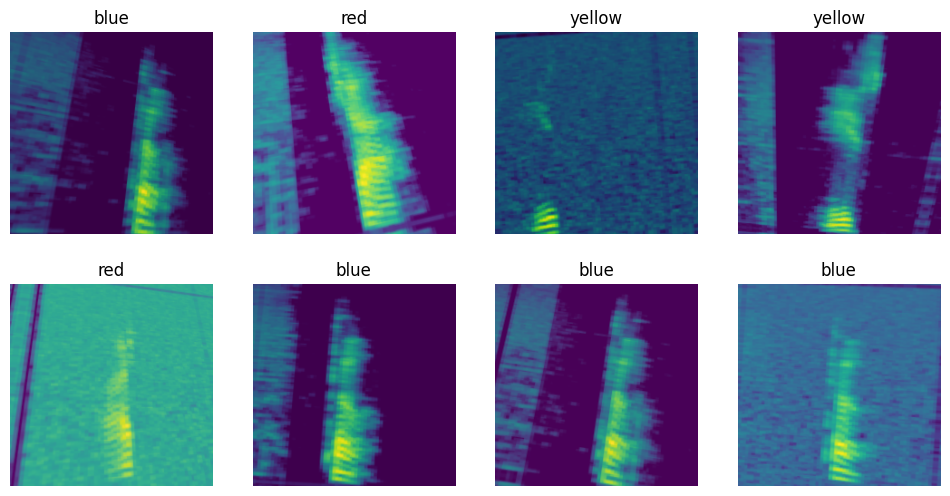

In [7]:
dls.show_batch(max_n=8, nrows=2, ncols=4)

In [ ]:
timm.list_models(pretrained=True)

In [ ]:
timm.list_models('levit*', pretrained=True)

In [ ]:
# Model name
model_name = 'levit_384.fb_dist_in1k'

# Create the model instance
model = timm.create_model(model_name, pretrained=True)

# Retrieve the default configuration
default_cfg = model.default_cfg
print(default_cfg)

In [8]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:04<00:00, 18.4MB/s]


SuggestedLRs(valley=0.0010000000474974513)

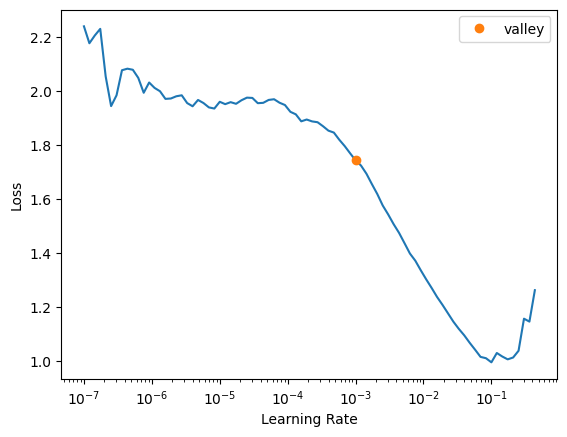

In [9]:
learn.lr_find() # find the learning rate

In [10]:
learning_rate = 0.0010000000474974513 # use the value from the lr_find() method above

In [11]:
initial_training_epochs = 5
learn.fine_tune(initial_training_epochs, base_lr=learning_rate) 

epoch,train_loss,valid_loss,error_rate,time
0,2.193405,1.453199,0.555556,00:22


epoch,train_loss,valid_loss,error_rate,time
0,1.439812,1.200064,0.500000,00:19
1,1.365708,0.942319,0.416667,00:17
2,1.209215,0.785012,0.305556,00:20
3,1.012292,0.558757,0.250000,00:20
4,0.866599,0.428977,0.138889,00:18


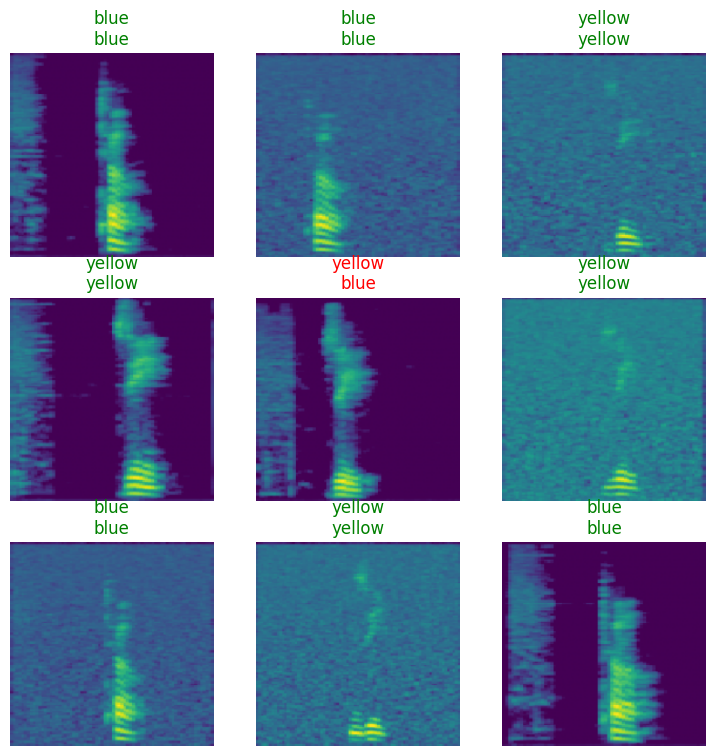

In [12]:
learn.show_results()

## Step 3: Let's see how our model did and what it had the most difficulty with

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

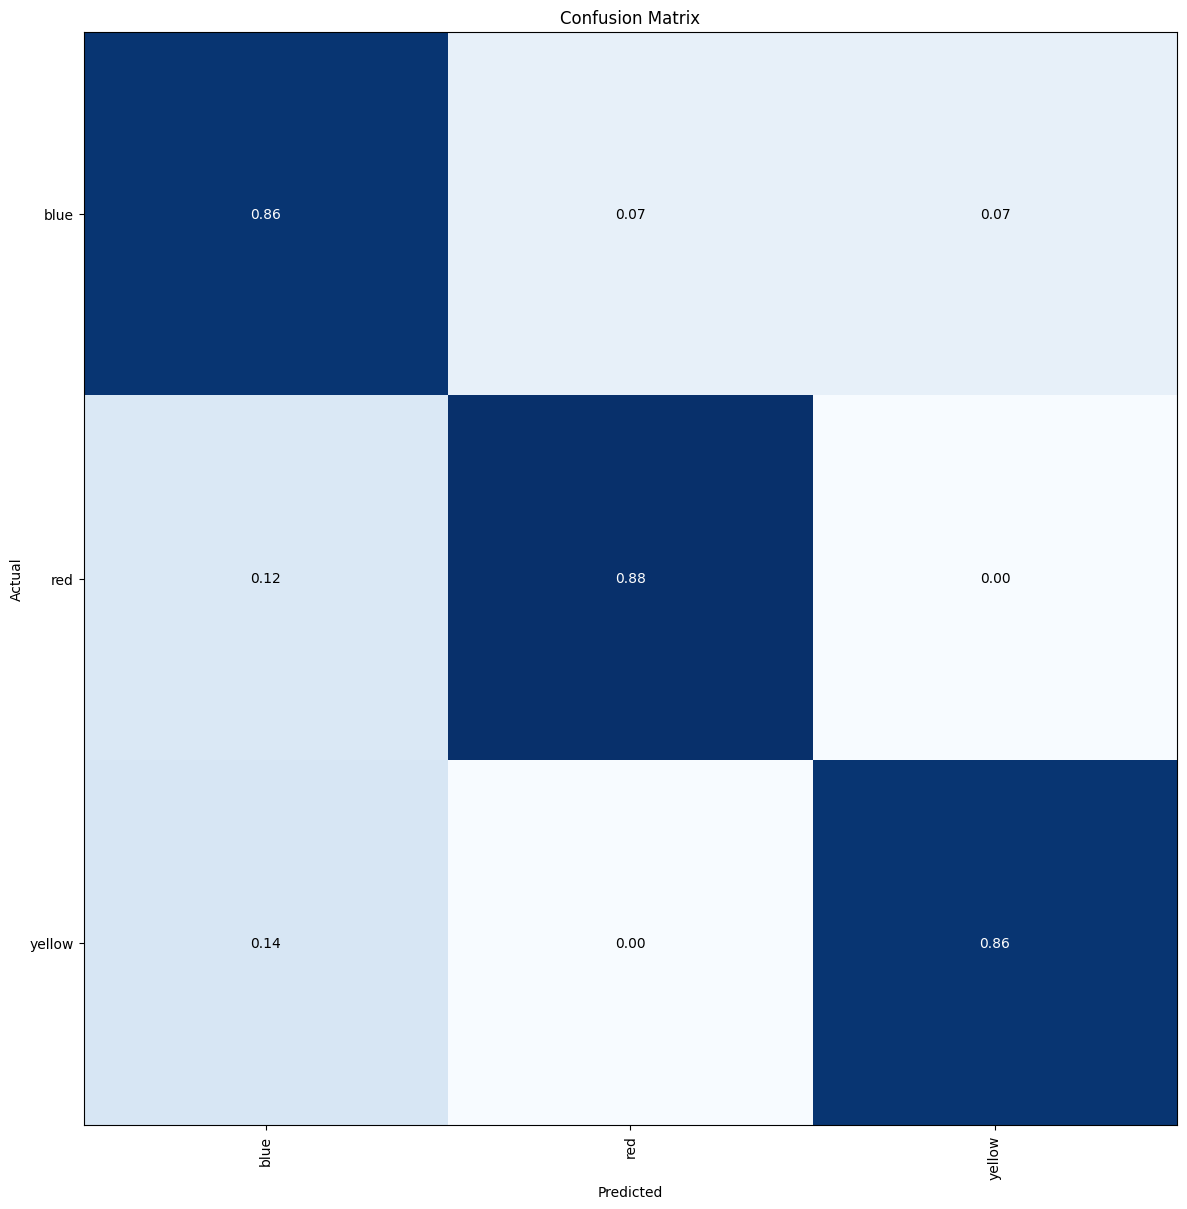

In [14]:
interp.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))

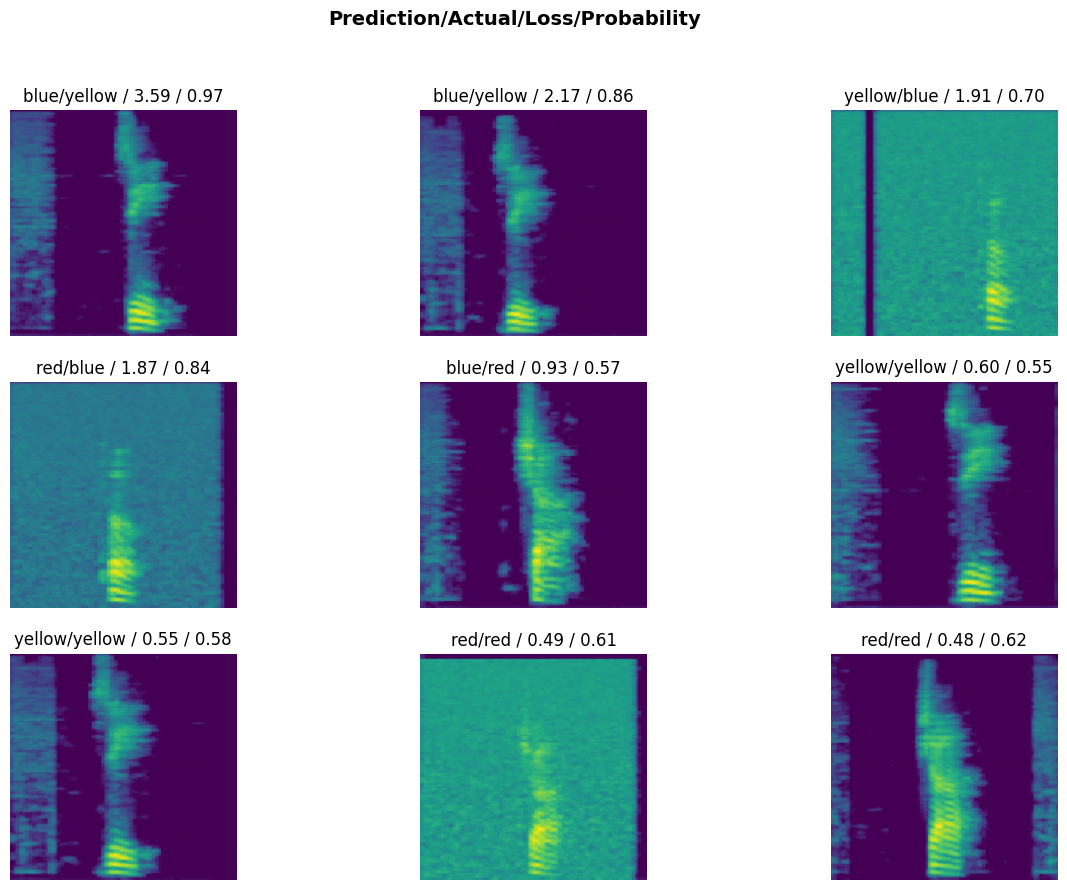

In [15]:
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
img_file = 'yarrow.jpg'
img_path = f"/workspace/images/TEST_IMAGES/{img_file}"
Image.open(img_path).to_thumb(256,256)

In [ ]:
category,_,probs = learn.predict(PILImage.create(img_path))
print(f"This is a: {category}.")

## Step 4: Let's clean the data

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [18]:
learn.export('/workspace/models/model.pkl')

## Step 5: Now We Train A Model Using What We've Learned

In [19]:
#first set how often the model should save a checkpoint file, these will be stored as .pth files, not .pkl
# not that .pth files will contain the model architecture, whereas .pkl files do not, which means .pth files are much larger in size
last_epoch_save = 5 # leave this value as zero if you are starting over from cleaned data
save_after_this_many_epochs = 5 # a .pth checkpoint file will be created every 5 epochs
model = resnet34
path = '/workspace/data/lakota_data' # ensure this points to your data
# Define the number of additional epochs you want to train for
additional_epochs = 20  # Set the total number of epochs to run in the cell below
learning_rate = 0.0010000000474974513 # use the value from the lr_find() method above
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),#RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=64)

In [21]:
from fastai.callback.core import Callback
from fastai.learner import load_learner
from fastai.data.core import DataLoaders

# SaveModelCallback will be triggered on each epoch, The default is 10 epochs, but you can set the amount using the save_after_this_many_epochs variable
class SaveModelCallback(Callback):
    def __init__(self, every=10, path='model', last_epoch_save=0):
        self.every = every
        self.path = path
        self.last_epoch_save = last_epoch_save

    def after_epoch(self):
        "Save the model every `self.every` epochs"
        if (self.epoch + 1) % self.every == 0:
            self.learn.save(f'{self.path}_epoch{self.epoch + (1+self.last_epoch_save)}')

# Define your data recover function, this function will return .pkl model from one of your checkpoint save files in the .pth format
# path = the path to your data (e.g. /workspace/data/TRAINING_DATA), path_to_pth_model = the path to your last saved .pth file
def recover_dl_from_pth(path, path_to_pth_model):
    dls = ImageDataLoaders.from_folder(path)
    learn = cnn_learner(dls, model) # be sure to use the same pretrained model here that you did for previous training, the model variable set above
    learn.load(path_to_pth_model)  # Load the model from the .pth file into the learn variable
    return learn # return the learn variable

# Load the previously trained model
recover_from_pth_file = False

if(recover_from_pth_file):
    # The code below will create a learner recovered from a checkpoint save
    # You will want to make sure that the pretrained model in recover_dl_from_pth() the same as what was used for fine tuning earlier
    learn_long = recover_dl_from_pth(path, '/workspace/models/model_epochEPOCH_NUM_HERE_TO_GET_TO_CORRECT_FLE.pth')
else:
    # This code will start at 0 or recover from a .pkl file
    if(last_epoch_save > 0):
        previous_model_path = '/workspace/models/model.pkl'  # replace with your actual model path
        learn_long = load_learner(previous_model_path) #note that this is creating a different learner than the one we used above
    else:
        learn_long = vision_learner(dls, model, metrics=error_rate) # create the learner
    # Ensure data loaders are set up
    learn_long.dls = dls # path is the path to our data, which was set earlier

# Instantiate the custom callback
# modify last_epoch_save to be the number of epochs the model was trained up to
save_model_callback = SaveModelCallback(every=save_after_this_many_epochs, path='/workspace/models/model', last_epoch_save = last_epoch_save)

# Continue training the model with the custom callback
learn_long.fine_tune(additional_epochs, base_lr=learning_rate, cbs=[save_model_callback])

# Save the updated model at the end
updated_model_path = f'/workspace/models/model_epoch{(last_epoch_save+additional_epochs)}.pkl'
learn_long.export(updated_model_path)

print("Training completed and model saved.")


epoch,train_loss,valid_loss,error_rate,time
0,0.564385,1.534029,0.555556,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.490006,1.887092,0.611111,00:19
1,0.483232,1.980259,0.611111,00:22
2,0.453789,1.924043,0.583333,00:22
3,0.397658,1.776537,0.500000,00:17
4,0.386572,1.524458,0.527778,00:21
5,0.367074,1.174876,0.416667,00:21
6,0.328419,0.859853,0.305556,00:18
7,0.292594,0.661442,0.222222,00:19
8,0.263544,0.569969,0.194444,00:20
9,0.243949,0.458047,0.138889,00:22


Training completed and model saved.


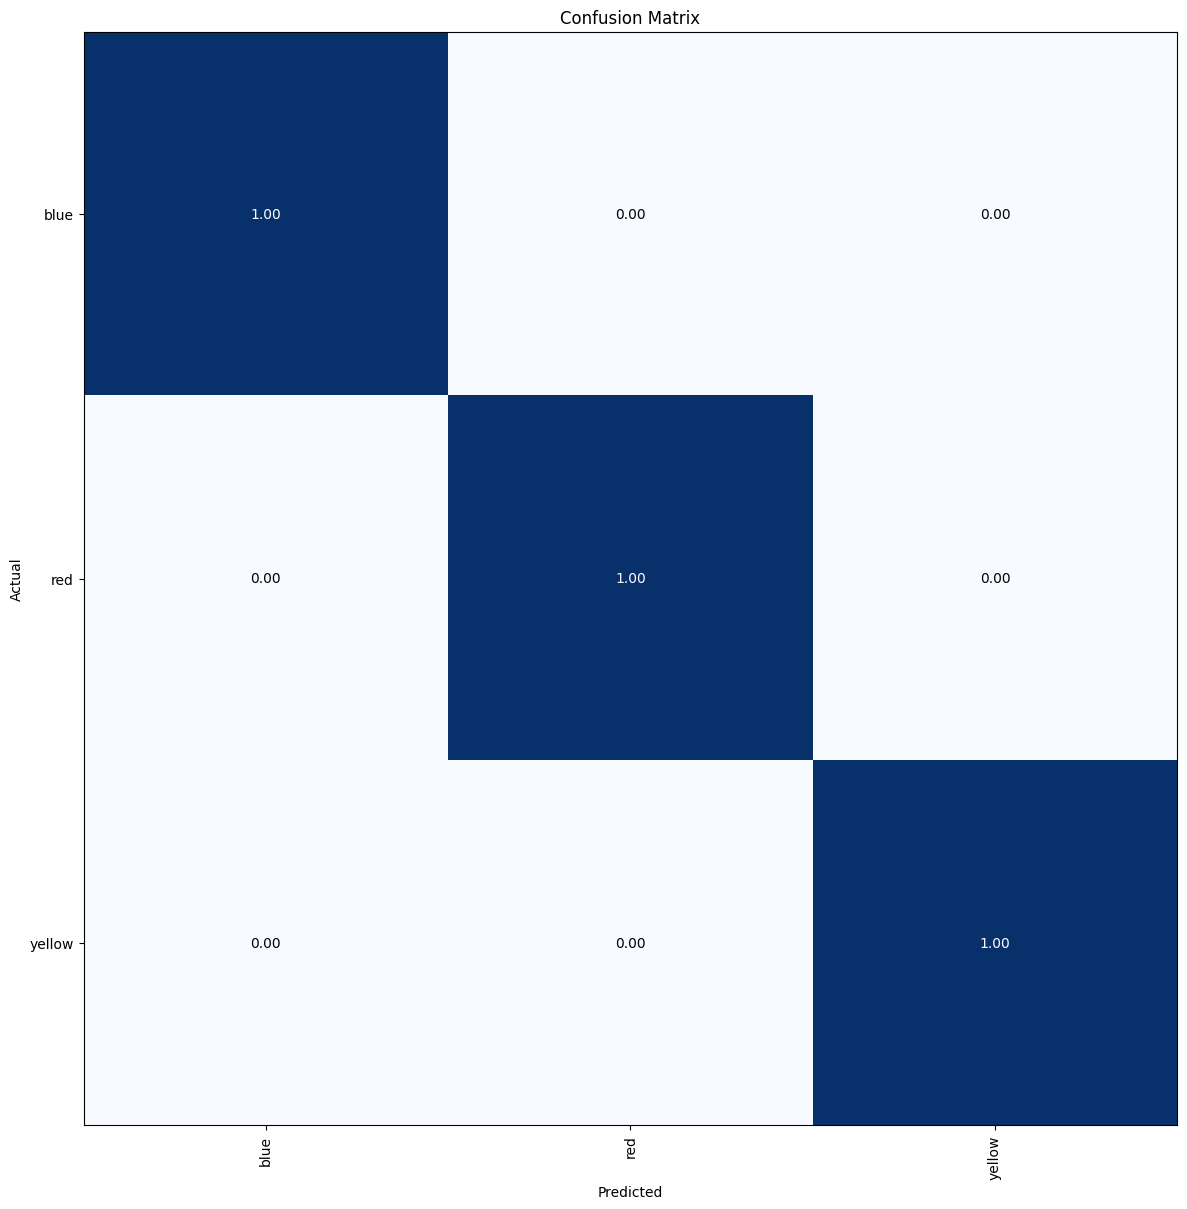

In [22]:
interp_long = ClassificationInterpretation.from_learner(learn_long)
interp_long.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))